# Mass spring damper demo
In this notebook we show how to model dynamic systems within the *dynsys_framework* and demonstrate the bootstrapping algorithm implemented in **Internal models with central pattern generator estimating and controlling gait dynamics**. The framework is demonstrated on [mass-spring-damper system](https://en.wikipedia.org/wiki/Mass-spring-damper_model) for which we must learn approximate model and infer the control policy.


## Mass-Spring-Damper model
Lets have an object of mass $m$ that moves on axis $x$. The object is linked to ground by string with stiffness $k$ and by damper with damper ratio $c$. The object is pushed by an external force $F_{external}$. This system is known as [mass-spring-damper](https://en.wikipedia.org/wiki/Mass-spring-damper_model) which is modelled with the following differential

$-kx - c\dot x + F_{external} = m\ddot x$

which we rewrite into first order differential

$
\dot x = v\\ 
\dot v = -\frac{k}{m} x - \frac{c}{m} v + u
$

where $u = \frac{F_{external}}{m}$ is rescaled external force.

We will now implement simulation of the mass-spring-damper.

In [3]:
# Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from dynsys_framework.execution_helpers.model_executor_parameters import ModelExecutorParameters
from utils import experiment_helpers
from utils import records


In [4]:
# Mass-Spring-Damper model


def mass_spring_damper_d(xv, u, k_param=2, c_param=1, m_param=5):
    xv_d = np.zeros((1,2))
    xv_d[0, 0] = xv[0, 1]
    xv_d[0, 1] = - (k_param/m_param) * xv[0, 0] - (c_param/m_param) * xv[0, 1] + u
    return xv_d

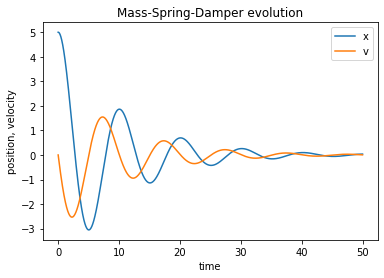

In [5]:
# Euler's method for numerical integration
step_size = 0.01
xvs = [np.asarray([5, 0]).reshape((1,2))]
ts = [0]
for i in range(5000):
    xvs.append(xvs[-1] + mass_spring_damper_d(xvs[-1], 0) * step_size)
    ts.append(ts[-1] + step_size)   
xvs = np.asarray(xvs)
ts = np.asarray(ts)

# plotting result    
plt.plot(ts, xvs[:, 0, 0], label="x")
plt.plot(ts, xvs[:, 0, 1], label="v")
plt.xlabel("time")
plt.ylabel("position, velocity")
plt.title("Mass-Spring-Damper evolution")
plt.legend()
plt.show()

### DynSys Framework implementation
The above implemented Euler's method works fine; however, for more complex systems with tens of variables, the implementation would become cumbersome and the code would be hard to manage. In the following code snippets we will show, how the numerical integration is specified within the *dynsys_framework*.


In [6]:
step_size = 0.01
iterations = 5000
results_path = "results"

# 1. Creating the model composed of linearly growing time and the mass-spring-damper

mep = ModelExecutorParameters() # Contains set of all involved variables and their functors/differentials 

# variable "t" : Time 
mep.add("d_t", # name of the variable (with prefix "d_" because it is being numerically integrated)
        (), # the differential needs no inputs
        lambda: 1, # time grows proportionally to integration steps
        default_initial_values={"t": 0} # time starts at 0
       )

# variable "xv": Mass-spring-damper state 
mep.add("d_xv", # name of the variable
        ("xv", "u"), # the differential needs state "xv" and external force "u"
        mass_spring_damper_d, # function taking two inputs computing the differential 
        default_initial_values={"xv": np.asarray([5, 0]).reshape((1,2))} # initial state
       )

# variable "u": external force (is a constant zero)
mep.add("u", # name of the variable, note since it is not differential it has no "d_" prefix.
        (), # no inputs needed
        lambda: 0. # its value is always zero
       )


# 2. Execution initialization
mod_exec = experiment_helpers.build_executor(mep, step_size)

# 3. Running the model simulation which will be saved into "results/msd_run.hdf5"
experiment_helpers.run_executor(mod_exec, iterations, results_path, "msd_run")

iter: 0, t: 0, cmp_time: 0.0002067089080810547
iter: 1000, t: 9.999999999999831, cmp_time: 0.0677955150604248
iter: 2000, t: 20.000000000000327, cmp_time: 0.041448354721069336
iter: 3000, t: 30.00000000000189, cmp_time: 0.04313778877258301
iter: 4000, t: 40.00000000000061, cmp_time: 0.0417788028717041
time: 0.23527908325195312


In [7]:
# Reading the experiment results from "results/msd_run.hdf5"
rec = records.load_records(os.path.join(results_path, "msd_run.hdf5"))[0]

records.print_record_shapes(rec)
# See that all variables and their derivations are stored in the hdf5 file
# name          shape

d_t:          (5000,)
d_xv:          (5000, 1, 2)
t:          (5000,)
u:          (5000,)
xv:          (5000, 1, 2)


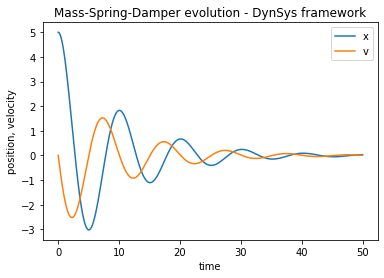

In [8]:
# the recorded variables are accessed by their names (rec is a python dictionary)
plt.plot(rec["t"], rec["xv"][:, 0, 0], label="x")
plt.plot(rec["t"], rec["xv"][:, 0, 1], label="v")
plt.xlabel("time")
plt.ylabel("position, velocity")
plt.title("Mass-Spring-Damper evolution - DynSys framework")
plt.legend()
plt.show()

### Forced mass-spring-damper system
Lets add some external force into our system.

In [34]:
step_size = 0.01
iterations = 5000
results_path = "results"

# 1. Creating the model composed of linearly growing time and the mass-spring-damper

mep = ModelExecutorParameters() # Contains set of all involved variables and their functors/differentials 

# variable "t" : Time 
mep.add("d_t", (), lambda: 1, default_initial_values={"t": 0})

# variable "xv": Mass-spring-damper state 
mep.add("d_xv", ("xv", "u"), lambda _xv, _u: mass_spring_damper_d(_xv, _u, k_param=20, c_param=20, m_param=0.1),
        default_initial_values={"xv": np.asarray([0, 0]).reshape((1,2))} 
       )


# variable "u": external force (is a constant zero)
mep.add("u", "t", lambda _t: np.maximum(np.sin(_t*1)-0.8, 0))


# 2. Execution initialization
mod_exec = experiment_helpers.build_executor(mep, step_size)

# 3. Running the model simulation which will be saved into "results/msd_run.hdf5"
experiment_helpers.run_executor(mod_exec, iterations, results_path, "msd_forced_run")

iter: 0, t: 0, cmp_time: 0.0005776882171630859
iter: 1000, t: 9.999999999999831, cmp_time: 0.07370328903198242
iter: 2000, t: 20.000000000000327, cmp_time: 0.05364847183227539
iter: 3000, t: 30.00000000000189, cmp_time: 0.052942752838134766
iter: 4000, t: 40.00000000000061, cmp_time: 0.06083035469055176
time: 0.2958180904388428


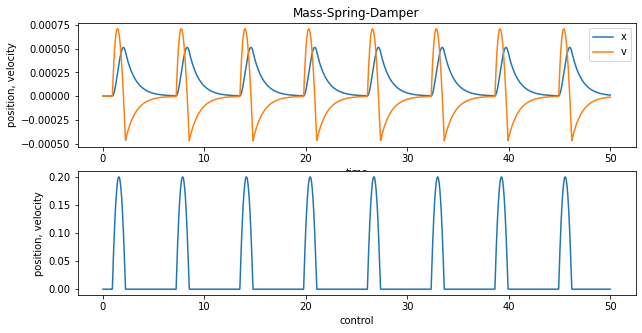

In [35]:
# Reading the experiment results from "results/msd_run.hdf5"
rec = records.load_records(os.path.join(results_path, "msd_forced_run.hdf5"))[0]
# the recorded variables are accessed by their names (rec is a python dictionary)
plt.subplot(211)
plt.plot(rec["t"], rec["xv"][:, 0, 0], label="x")
plt.plot(rec["t"], rec["xv"][:, 0, 1], label="v")

plt.xlabel("time")
plt.ylabel("position, velocity")
plt.title("Mass-Spring-Damper")
plt.legend()
plt.subplot(212)
plt.plot(rec["t"], rec["u"], label="u")
plt.xlabel("control")
plt.ylabel("position, velocity")

plt.show()

## Goal-oriented bootstrapping of forward models
Lets say, that we have been given a repeating position trajectory $x^*(t)=x^*(t+T)$ which we want to observe on our mass-spring-damper $x^*(t) \approx x(t)$. We are able to command the external force $u$ and observe its position $x$. However, **we don't know the dynamic relation between external force $u$ and the observed position $x$**. 

This is where the proposed algorithm comes in. It is able to explore unknown dynamics and synthesise periodic command signal (gait) that produces the desired behavior $x^*$.

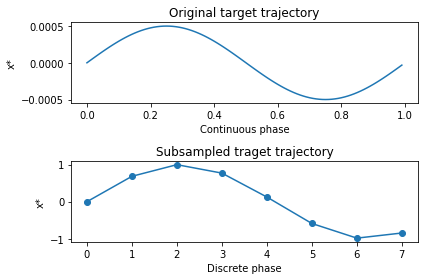

In [10]:
# Target
pos_rescale = 2000
granularity = 8
trajectory = np.sin(2 * np.pi * np.arange(100) / 100) * 0.0005

# Transforming targe
y_ref = np.zeros((1, 1, 1, granularity))
y_mask = np.ones((1, 1, 1, granularity))
y_mask_minmax = np.zeros((1, 1, 1, granularity))

jump = int(len(trajectory)/granularity)
y_ref[0, 0, 0, :] = trajectory[[i * jump for i in range(granularity)]] * pos_rescale

plt.subplot(211)
plt.plot(np.arange(len(trajectory))/len(trajectory),trajectory)
plt.title("Original target trajectory")
plt.xlabel("Continuous phase")
plt.ylabel("x*")
plt.subplot(212)
plt.plot(y_ref[0, 0, 0, :], 'o-')
plt.title("Subsampled traget trajectory")
plt.xlabel("Discrete phase")
plt.ylabel("x*")
plt.tight_layout()
plt.show()



In [55]:
import models.limit_cycle_controller_contextual as M


step_size = 0.01
iterations = 60000
results_path = "results"

mep = ModelExecutorParameters() # Contains set of all involved variables and their functors/differentials 

# MASS-SPRING-DAMPER
# variable "t" : Time 
mep.add("d_t", (), lambda: 1, default_initial_values={"t": 0})
# variable "xv": Mass-spring-damper state 
mep.add("d_xv", ("xv", "u"), lambda _xv, _u: mass_spring_damper_d(_xv, _u, k_param=20, c_param=20, m_param=0.1), 
        default_initial_values={"xv": np.asarray([0, 0]).reshape((1,2))})
# variable "x_observed": observed position (taken from the mass-spring-damper state)
mep.add("x_observed", "xv", lambda xv: xv[0, 0] * pos_rescale)

# BOOTSTRAPPING CONTROLLER
# The set of variables
mep.add("u_regularization", (), lambda: 0.)
M.model(mep,
          epicycle_size=16, phase_velocity=1,
          motor_dim=1, motor_segments_num=granularity,
          sensory_dim=1, sensory_segments_num=granularity,
          context_num=10,
          model_quality_lower_bound=1e0, model_quality_upper_bound=1e1,
          performance_quality_upper_bound=2e1,
          perturbation_probability=0.1,
          is_model_learned=True,
          is_control_learned=True, 
          is_model_lr_external=True,
          dynamic_outer_threshold=False,
          regularization_name="u_regularization"
          )

# COUPING THE BOOTSTRAPPING CONTROLLER WITH MASS-SPRING-DAMPER

# targets setup # TODO
mep.add(M.SENSORY_REFERENCE, (), lambda : y_ref)
mep.add(M.SENSORY_REFERENCE_MASK, (), lambda : y_mask)
mep.add(M.SENSORY_REFERENCE_MINMAX_MASK, (), lambda : y_mask_minmax)

# sensory input
mep.add(M.SENSORY_INPUT, "x_observed", lambda x: x.reshape(1, 1))

# motor command
mep.add("u", M.MOTOR_COMMAND, lambda u: u)

# CPG setup
mep.add(M.MOTOR_PERTURBATION, (), lambda: 0)
mep.add(M.STATE_PERTURBATION, (), lambda: 0)

# learning rage
mep.add(M.MODEL_LEARNING_RATE, "t", lambda _t: 0. if _t<50. else 10.)

# 2. Execution initialization
mod_exec = experiment_helpers.build_executor(mep, step_size)

# 3. Running the model simulation which will be saved into "results/msd_run.hdf5"
experiment_helpers.run_executor(mod_exec, iterations, results_path, "msd_bootstrapping_run")

iter: 0, t: 0, cmp_time: 0.008414745330810547
iter: 1000, t: 9.999999999999831, cmp_time: 4.914901494979858
iter: 2000, t: 20.000000000000327, cmp_time: 4.916302680969238
iter: 3000, t: 30.00000000000189, cmp_time: 4.903739929199219
iter: 4000, t: 40.00000000000061, cmp_time: 4.895573139190674
iter: 5000, t: 49.99999999999862, cmp_time: 4.903177261352539
iter: 6000, t: 59.99999999999663, cmp_time: 4.926316976547241
iter: 7000, t: 69.9999999999989, cmp_time: 4.895402431488037
iter: 8000, t: 80.00000000000402, cmp_time: 4.8885955810546875
iter: 9000, t: 90.00000000000914, cmp_time: 4.904635190963745
iter: 10000, t: 100.00000000001425, cmp_time: 4.905593395233154
iter: 11000, t: 110.00000000001937, cmp_time: 4.907417297363281
iter: 12000, t: 120.00000000002449, cmp_time: 4.903661012649536
iter: 13000, t: 130.00000000002674, cmp_time: 4.900025129318237
iter: 14000, t: 140.00000000001765, cmp_time: 4.887243986129761
iter: 15000, t: 150.00000000000855, cmp_time: 4.922632932662964
iter: 16000

In [56]:
# Reading the experiment results from "results/msd_run.hdf5"
rec = records.load_records(os.path.join(results_path, "msd_bootstrapping_run.hdf5"))[0]

#records.print_record_shapes(rec) 
# See that all variables and their derivations are stored in the hdf5 file
# name          shape

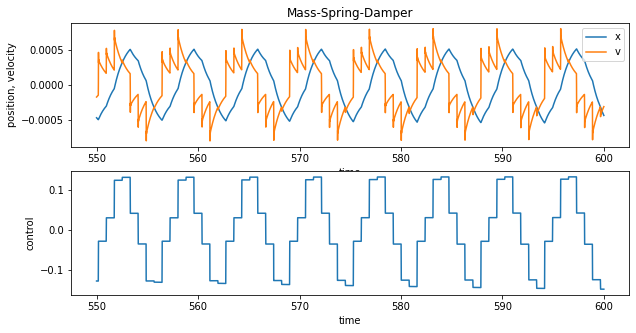

In [62]:
# the recorded variables are accessed by their names (rec is a python dictionary)
plt.subplot(211)
plt.plot(rec["t"][-5000:], rec["xv"][-5000:, 0, 0], label="x")
plt.plot(rec["t"][-5000:], rec["xv"][-5000:, 0, 1], label="v")
# plt.plot(rec["t"], rec["xv"][:, 0, 1], label="v")

plt.xlabel("time")
plt.ylabel("position, velocity")
plt.title("Mass-Spring-Damper")
plt.legend()
plt.subplot(212)
plt.plot(rec["t"][-5000:], rec["u"][-5000:, 0, 0], label="u")
plt.xlabel("time")
plt.ylabel("control")

plt.show()

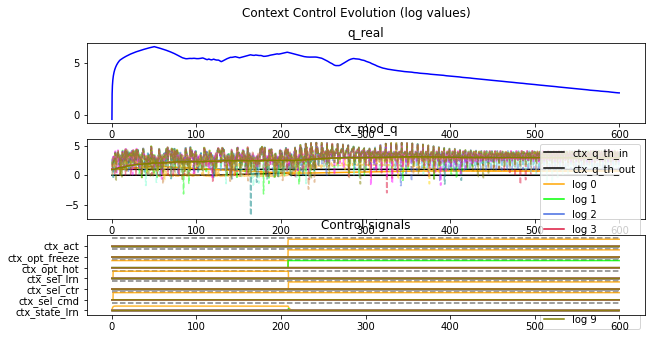

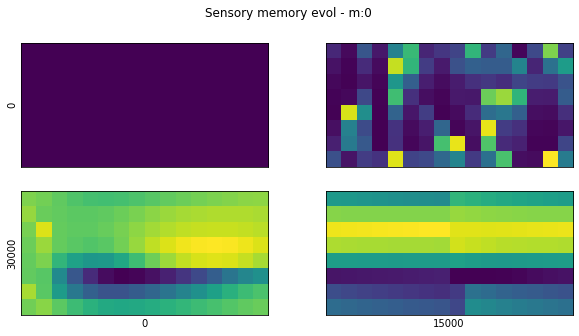

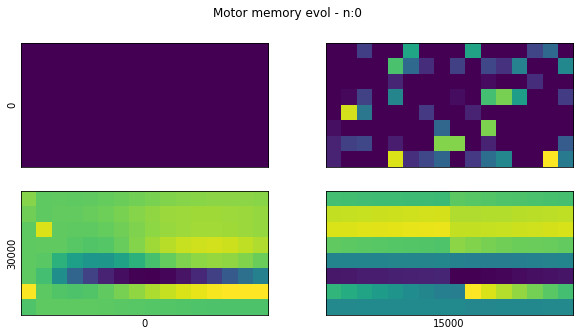

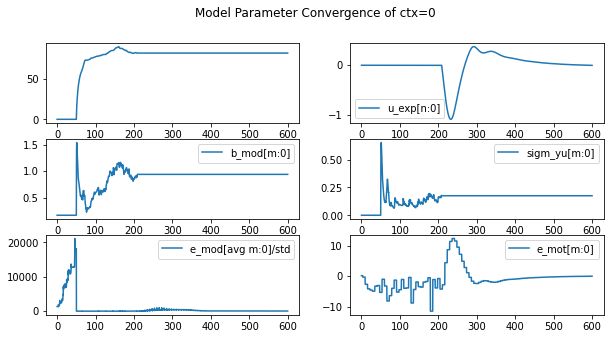

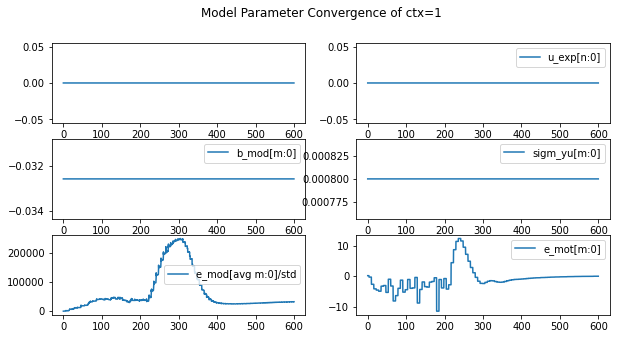

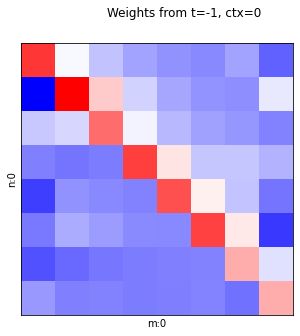

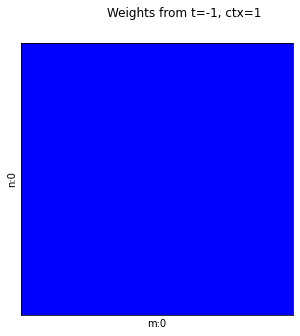

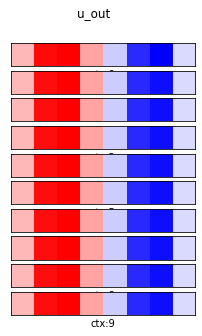

In [58]:
from models.visuals import limit_cycle_controller, limit_cycle_controller_contextual
plt.rcParams['figure.figsize'] = [10, 5]

limit_cycle_controller_contextual.context_control_evol(rec, plt.figure())
limit_cycle_controller.y_mem_evolution(rec, plt.figure(), sensor_m=0, size=2)
limit_cycle_controller.u_mem_evolution(rec, plt.figure(), motor_n=0, size=2)

limit_cycle_controller_contextual.model_context_parameter_convergence(rec, plt.figure(), context=0)
limit_cycle_controller_contextual.model_context_parameter_convergence(rec, plt.figure(), context=1)

limit_cycle_controller_contextual.multi_io_matricies(rec, plt.figure(), ctx=0, sensor_modewise_norming=True)
limit_cycle_controller_contextual.multi_io_matricies(rec, plt.figure(), ctx=1, sensor_modewise_norming=True)

limit_cycle_controller_contextual.multi_control_outputs(rec, plt.figure())


plt.show()
